#Fetch Rewards Data Analysis Challenge

Hello! This notebook entails all the information used for the analysis of the given data set as a challenge for the position of Data Analyst at Fetch Rewards.

In this project, the **primary SQL dialect used is MySQL** as this enabled easy database creation and also provided easy APIs for python. Hence aiding in efficient data cleaning. 
More information on MySQL can be obtained here: https://www.mysql.com/

## **QUESTION 1** 
##Entity-Relationship (ER) Diagram.  


It is essential to visualize the provided data in the form of an ER diagram in order to understand the relations between different tables. These entities will then be used in Exploratory Data Analysis (EDA) to address business requirements.

To make an ER diagram, I have used Lucid Charts (www.lucidcharts.com). The diagram below provides a simplified, structured, relational diagram to represent the unstructured data.

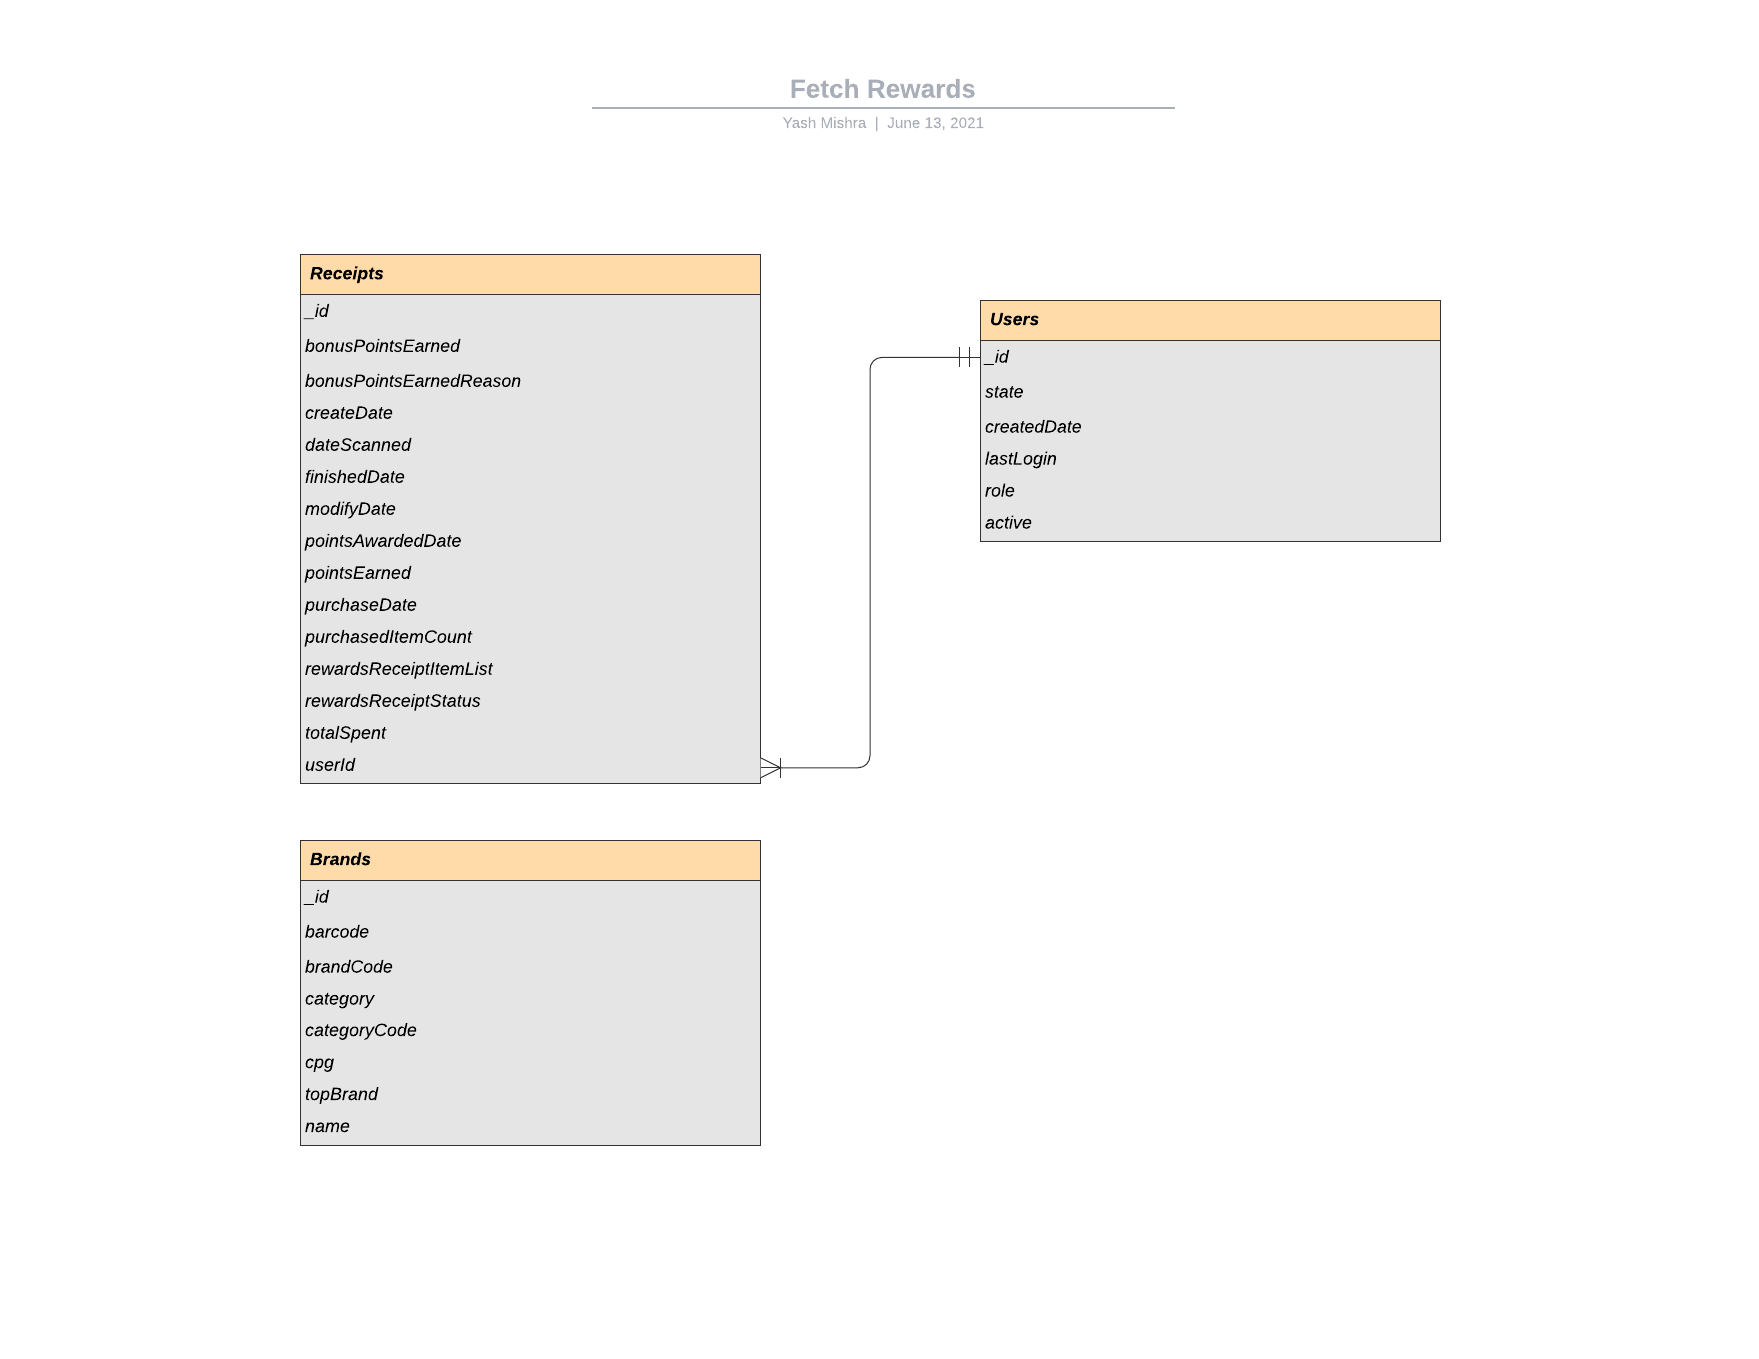

The ER diagram represents that one user can have multiple receipts but each receipt only points to a single user.
The user_id in the receipts table is the primary key and _id in the users is the foreign key.

It is also essential to note that one receipt can point to many items as rewardsReceiptItemList stores a list of items. However, the diagram would have been much better with more data, eg; a table containing information about PurchasedItems.


As a side note, storing many items in a list is often considered bad practice as it de-normalizes the data and makes the purpose of using relational databases irrelevant. Therefore, I would have avoided using such a column and would have preferred to further normalize the data.

##Data Collection

This section takes a look at the data and how it is structured.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading the files as dataframes.


In [2]:
receipts = 'receipts.json'
brands = 'brands.json'
users = 'users.json'

In [3]:
receipts = pd.read_json('receipts.json', lines=True)
brands = pd.read_json('brands.json', lines=True)
users = pd.read_json('users.json', lines=True)

In [4]:
receipts.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


In [5]:
brands.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827


In [6]:
users.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


## **Question 2**
##Using queries to answer questions from a business stakeholder.

Tables were created in MySQL using the json files provided. Primary keys and foreign keys were assigned as provided in the ER diagram.

For the purpose of this assignment, the following 2 questions were answered.

**Question 1**: When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

**Query**:

```
SELECT rewardsReceiptStatus, SUM(purchasedItemCount) AS greater_revenue
FROM Receipt
GROUP BY rewardsReceiptStatus
ORDER BY SUM(purchasedItemCount) DESC
LIMIT 1
```


**Question 2**: When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

**Query**:

```
SELECT rewardsReceiptStatus, AVG(TotalSpent) AS greater_revenue
FROM Receipt
GROUP BY rewardsReceiptStatus
ORDER BY AVG(TotalSpent) DESC 
LIMIT 1
```

##**Question 3**
##Data Quality Issues

**Cleaning Receipts data**

In [7]:
receipts['_id'] = pd.json_normalize(receipts['_id'])

In [8]:
receipts['createDate'] = pd.json_normalize(receipts['createDate'])

In [9]:
receipts['dateScanned'] = pd.json_normalize(receipts['dateScanned'])

In [10]:
receipts['modifyDate'] = pd.json_normalize(receipts['modifyDate'])

### Issue 1 -->

**Count of NULL values in receipt**

In [35]:
receipts.isnull().sum()

_id                          0
bonusPointsEarned          575
bonusPointsEarnedReason    575
createDate                   0
dateScanned                  0
finishedDate               551
modifyDate                   0
pointsAwardedDate          582
pointsEarned               510
purchaseDate               448
purchasedItemCount         484
rewardsReceiptItemList     440
rewardsReceiptStatus         0
totalSpent                 435
userId                       0
dtype: int64

As seen in the data above, data in the receipts table contains alot of NULL values. Although, some of the null values can be replaced using different approaches such as zero replacement, mean value replacement or mode replacement.

It is impossible to fill in data in the columns which have Date/time information. Therefore the only way to out is to get rid of such rows. Such columns include finishedDate, pointsAwardedDate, purchaseDate.

It is interesting to observe there are 484 NULL values in the purchasedItemCount colummn. This means that there is no information on the number of items purchased in a transaction. This is a serious problem as it can affect the profit margins. The problem can be solved by proper data entry or counting the number the of items in the rewardsReceiptItemList.

### Issue --> 2

Analyzing brands data...

In [38]:
brands.isnull().sum()

_id               0
barcode           0
category        155
categoryCode    650
cpg               0
name              0
topBrand        612
brandCode       234
dtype: int64

As seen above, there is missing information for category, categoryCode, topBrand and brandCode.

In [58]:
unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(brands.columns.values):
    unique_values.loc[row] = [brands[row].nunique()]

unique_values

,Unique Values
_id,1167
barcode,1160
category,23
categoryCode,14
cpg,2
name,1156
topBrand,2
brandCode,897


##**Question 4**
##Email communication to the stake holders with additional questions.

The email communication with the stakeholders is provided in a word document that will is available in the same github repository as this notebook.

It was fun doing this coding challenge and I look forward to hear about the next steps. Thanks! :)